In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm import tqdm

import time
from IPython.display import clear_output
from scipy.interpolate import make_interp_spline

## Table of Contents
**[Part 1: Separable Data](#part1)**
 - **[Part 1a: Visualizing the Perceptron Classifier](#part1a)**
 - **[Part 1b: Trying with dimensions, $\alpha$, and samples sizes](#part1b)**
 - **[Part 1c: Looking at Graphs](#part1c)**

 **[Part 2: Separable Data](#part2)**
 - **[Part 1a: Visualizing the Perceptron Classifier](#part2a)**
 - **[Part 1b: Trying with dimensions, $m$, and samples sizes](#part2b)**
 - **[Part 1c: Looking at Graphs](#part2c)**

 **[Part 3: Bayes Risk](#part3)**

## Creating My Classifier

In [54]:
def calculateMetric(y_test, y_pred, metric = "Accuracy"):
    accuracy = np.sum(y_pred == y_test)/len(y_test)
    if metric == "Accuracy":
        #print(f"Accuracy: {accuracy:.3f}")
        return accuracy
    elif metric == "Risk":
        #print(f"Risk: {1 - accuracy:.3f}")
        return 1 - accuracy
    else:
        #print("Enter either Risk or Accurach")
        return

In [55]:
class PerceptronClassifier:
    def __init__(self) -> None:
        self.X = None
        self.y = None
        self.ycopy = None
        self.weights = None
        self.bias = None
        self.converged = None
        
        self.updates = 0
        
        self.weightshistory = []
        
        self.xmin = -1.1
        self.ymin = -1.1
        self.xmax = 1.1
        self.ymax = 1.1
         
    def fit(self, X_train, y_train, max_iters=1000, visualize=False, speed=1):
        assert X_train.shape[0] == len(y_train)
    
        self.X = X_train
        self.ycopy = y_train
        self.y = y_train.reshape(-1, 1)
        
        self.weights = np.zeros((X_train.shape[1], 1))
        self.bias = 0
        self.converged = False
        self.repeat= False
        
        self.updates = 0

        # Repeat the following until max_epochs or convergence
        for _ in range(max_iters):
            self.converged = True
            for i in range(len(y_train)):
                # Make prediction for each data point
                prediction = np.dot(X_train[i], self.weights) + self.bias
                # Check if misclassified
                if y_train[i] * prediction <= 0:
                    # Update weights and bias
                    self.weights += y_train[i] * X_train[i].reshape(-1, 1)
                    self.bias += y_train[i]
                    self.converged = False
                    self.updates += 1

                    # Visualize if necessary
                    if visualize:
                        self.visualize()
                        time.sleep(speed)
                        pass

            if self.converged:
                break

        if self.converged:
            print(f"Converged after {self.updates} individual updates.")
        else:
            print(f"Did not converge after {max_iters} epochs and {self.updates} individual updates.")
            
    #Watch the graph go
    def visualize(self):
        weights = self.weights.flatten()
        
        randomX = np.linspace(-20, 20, 100)
        
        colors = {1: 'blue', -1: 'red'}

        dim1 = randomX
        dim2 = (-weights[0] / weights[1]) * dim1 - self.bias / weights[1]

        plt.plot(dim1, dim2, label='Decision Boundary', color='black', linestyle='--')
        plt.scatter(x=self.X[:, 0], y=self.X[:, 1], c=[colors[label] for label in self.ycopy], alpha = 0.5)

        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.xlim(self.xmin,self.xmax)
        plt.ylim(self.ymin, self.ymax)
        plt.title(f'Visualization of 2 Dimensions with Boundary at Update {self.updates}')
        clear_output(wait=True)
        plt.show()
        
    def setGraphDim(self, x_min, x_max, y_min, y_max):
        self.xmin = x_min
        self.xmax = x_max
        self.ymin = y_min
        self.ymax = y_max
        
    def predict(self, X_test):
        predictions = np.sign(np.matmul(X_test, self.weights) + self.bias)[:,0]
        return predictions


 <a id="part1"> </a>
 ## Part 1 - Generating Separable Data:

In [56]:
def generateLinearData1(dimensions, samples, alpha):
    assert 0 <= alpha <= 1
    
    y = 2 * np.random.binomial(n = 1, p = 0.5, size = samples) - 1
    
    firstDim = []
    
    for i in y:
        if i == 1:
            firstDim.append(np.random.uniform(low = -1, high = -alpha))
        else:
            firstDim.append(np.random.uniform(low = alpha, high = 1))
    
    otherDim = np.random.uniform(low = -1, high = 1, size = (samples, dimensions - 1))
    X = np.column_stack([firstDim, otherDim])
    
    return X, y

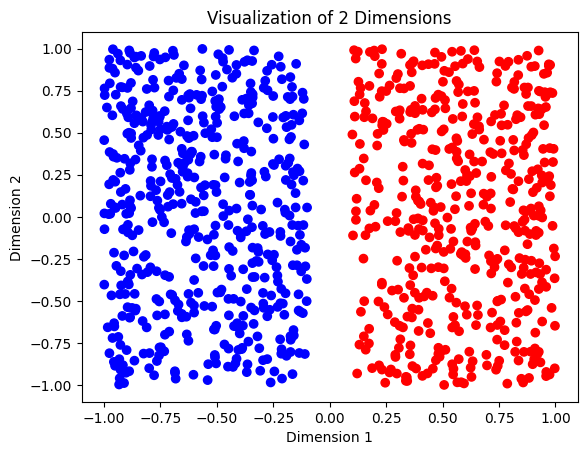

In [57]:
X, y = generateLinearData1(dimensions= 2, samples = 1000, alpha = 0.1)

colors = {1: 'blue', -1: 'red'}

plt.scatter(x=X[:, 0], y=X[:, 1], c=[colors[label] for label in y])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Visualization of 2 Dimensions')
plt.show()

 <a id="part1a"> </a>
### Creating animation of how the Decision Boundary moves every iteration

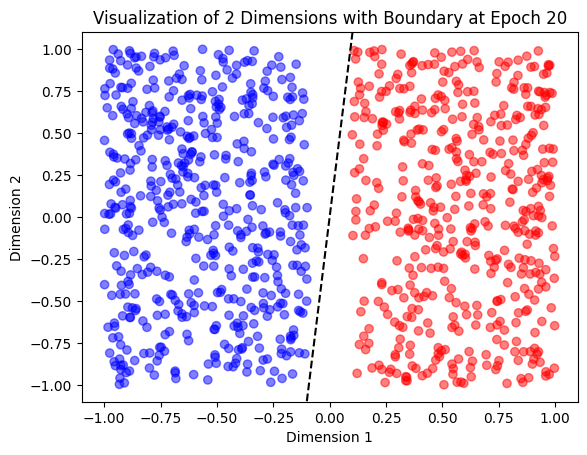

Converged after 20 iterations


In [58]:
testing = PerceptronClassifier()
testing.fit(X, y, visualize= True)

In [59]:
X_test, y_test = generateLinearData1(dimensions= 2, samples = 10000, alpha = 0.2)
y_pred = testing.predict(X_test)
accuracy = calculateMetric(y_test, y_pred, metric = "Accuracy")

<a id = "part1b"></a>
### Trying Different dimensions, $a$, and samples sizes

Building faster data generation:

In [60]:
def generateLinearData(dimensions, samples, alpha):
    assert 0 <= alpha <= 1
    
    num1 = np.random.binomial(n = samples, p = 0.5)
    num0 = samples - num1
    
    firstDim = np.concatenate([np.random.uniform(low = alpha, high = 1, size = num0), np.random.uniform(low = -1, high = -alpha, size = num1)])
    otherDim = np.random.uniform(low = -1, high = 1, size = (samples, dimensions - 1))
    
    X = np.column_stack([firstDim, otherDim])
    y = np.concatenate([np.full(shape = num0, fill_value=-1), np.full(shape = num1, fill_value= 1)])
    
    return X, y

In [61]:
'''
%%timeit 
X, y = generateLinearData(dimensions= 10, samples = 10000, alpha = 0.2)
'''

'\n%%timeit \nX, y = generateLinearData(dimensions= 10, samples = 10000, alpha = 0.2)\n'

In [62]:
'''
%%timeit 
X2, y2 = generateLinearData2(dimensions= 10, samples = 10000, alpha = 0.2)
'''

'\n%%timeit \nX2, y2 = generateLinearData2(dimensions= 10, samples = 10000, alpha = 0.2)\n'

Checking samples were generated correctly by printing the first element and checking that it matches the sign of the first label:

In [63]:
X, y = generateLinearData(dimensions= 10, samples = 10000, alpha = 0.2)

print("For Dim 0:")
print(f"Mean for Class 1: {np.mean(X[y == 1,0]):.2f}") 
print(f"Mean for Class -1: {np.mean(X[y== -1,0]):.2f}")


For Dim 0:
Mean for Class 1: -0.59
Mean for Class -1: 0.59


Selecting range of parameters:

In [64]:
alphas = np.linspace(start = 0, stop = 1, num = 9)
dimensions = [2, 5, 10, 15, 20, 30,40,50]
samples = [10,50,100,1000,5000,10000]

In [65]:
test_size = 10000
results = {}

for a in tqdm(alphas):
    for d in dimensions:   
        X_test, y_test = generateLinearData(dimensions = d, samples = test_size, alpha = a)
        for s in samples:
            total_iter = 0
            total_accuracy = 0
            for i in range(50):
                model = PerceptronClassifier()
                #print(f"m = {a:.2f}, dimensions = {d}, samples = {s}")
                X_train, y_train = generateLinearData(dimensions = d, samples = s, alpha= a)
                model.fit(X_train, y_train, max_epochs = 100)
                y_pred = model.predict(X_test)
                total_accuracy += calculateMetric(y_pred, y_test)
                total_iter += model.updates
            results[a,d,s] = [total_iter/50, total_accuracy/50]

100%|██████████| 9/9 [01:03<00:00,  7.02s/it]


 <a id="part1c"> </a>
## Analysing the Graphs

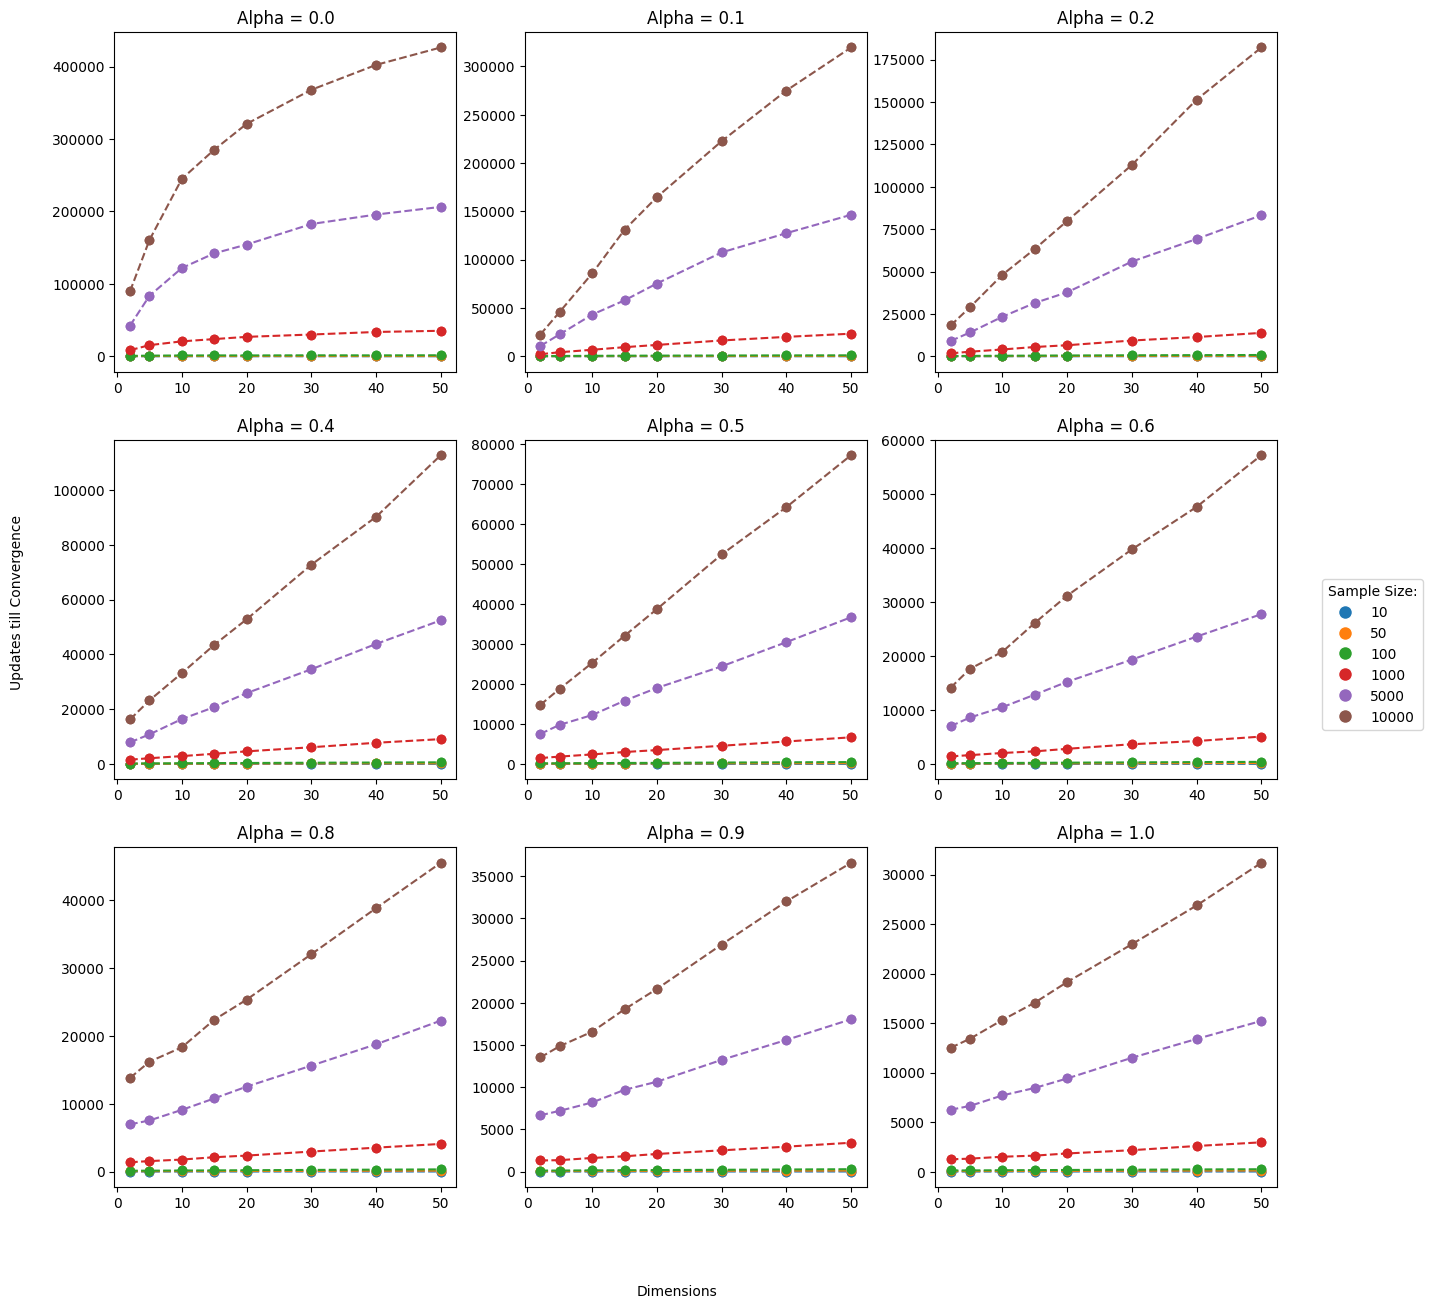

In [66]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(samples)]
converged_colors = dict(zip(samples, colors))

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, alpha in enumerate(alphas):
    selected_alpha = {k: v for k, v in results.items() if k[0] == alpha}

    for s in samples:
        selected_samples = {k: v for k, v in selected_alpha.items() if k[2] == s}

        plot_x = [sublist[1] for sublist in selected_samples.keys()]
        plot_y = [sublist[0] for sublist in selected_samples.values()]

        row = 0
        if i > 2:
            row = 1
        if i > 5:
            row = 2

        scatter = axs[row, i % 3].scatter(x=plot_x, y=plot_y, c=converged_colors[s], label=f"Graph for Samples {s}")

        axs[row, i % 3].set_title(f"Alpha = {alpha:.1f}")

        axs[row, i % 3].plot(plot_x, plot_y, linestyle='--', marker='o', color=converged_colors[s])

fig.text(0.5, 0.04, 'Dimensions', ha='center', va='center')
fig.text(0.06, 0.5, 'Updates till Convergence', ha='center', va='center', rotation='vertical')

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=converged_colors[s], markersize=10, linestyle='--', label=f'{s}') for s in samples]
fig.legend(handles=legend_labels, title='Sample Size:', loc='center right')

plt.show()

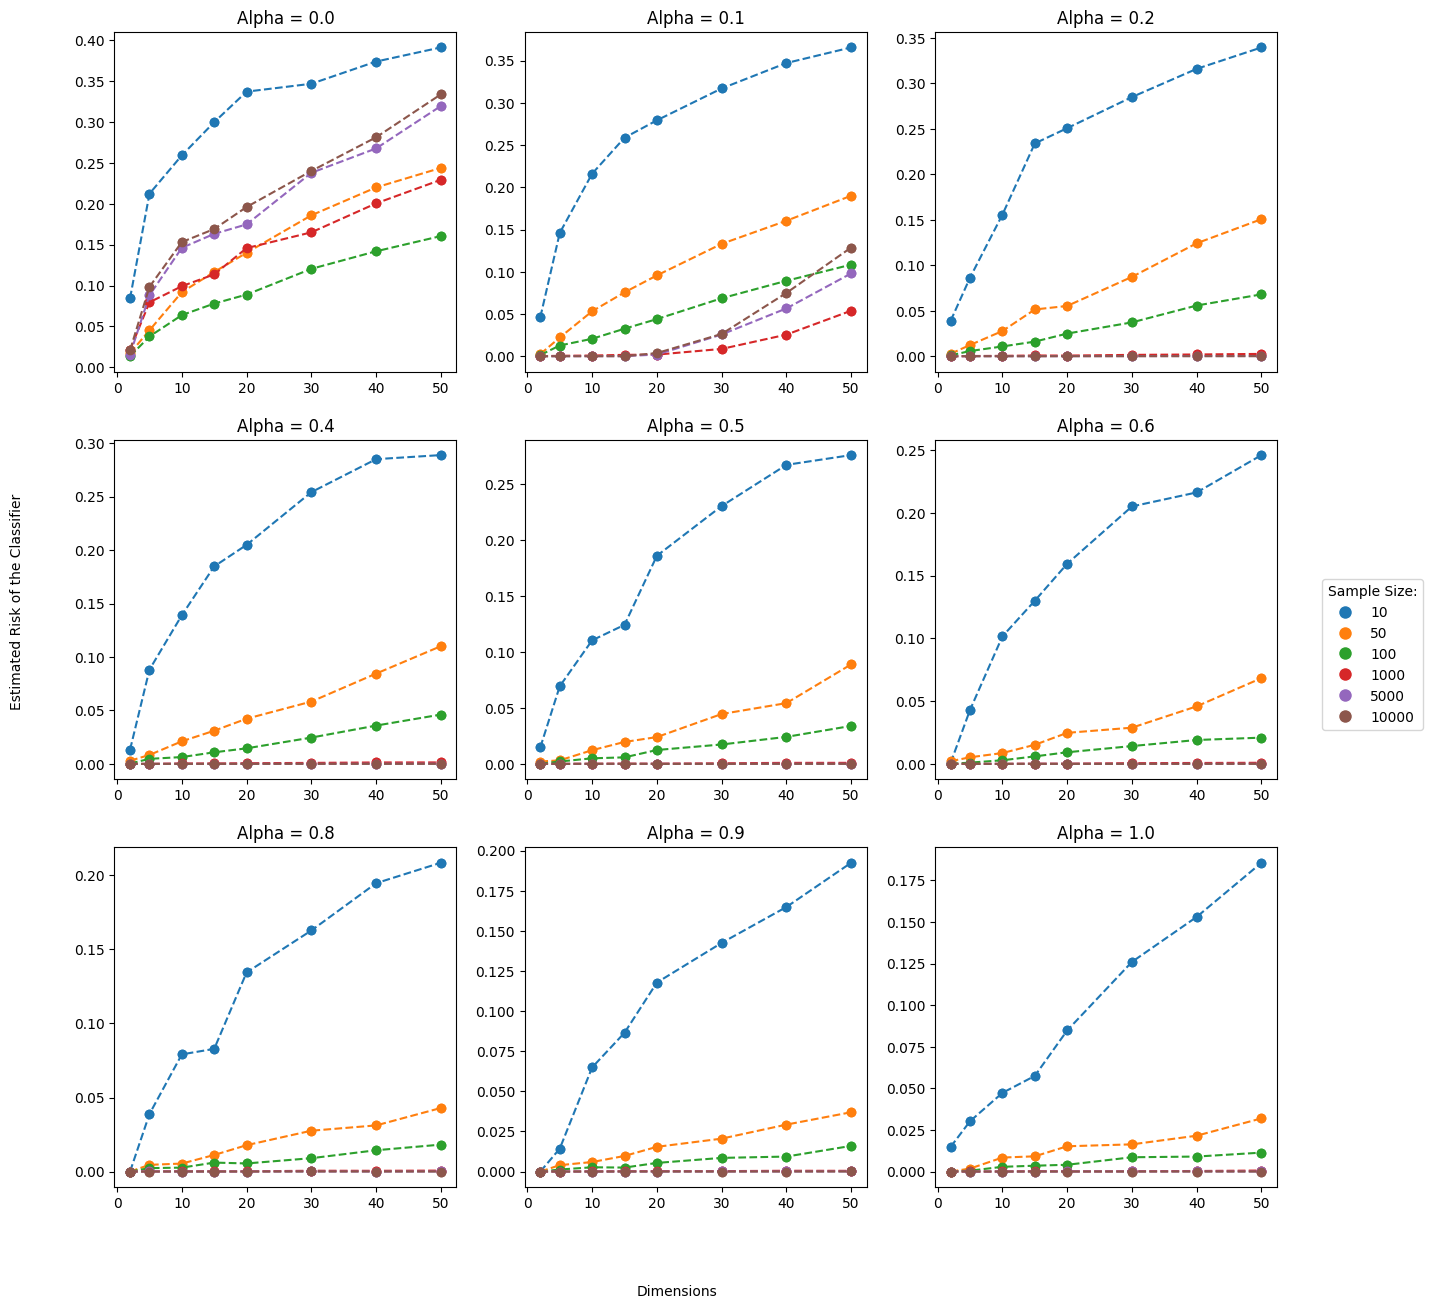

In [67]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]
converged_colors = dict(zip(samples, colors))

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, alpha in enumerate(alphas):
    selected_alpha = {k: v for k, v in results.items() if k[0] == alpha}

    for s in samples:
        selected_samples = {k: v for k, v in selected_alpha.items() if k[2] == s}

        plot_x = [sublist[1] for sublist in selected_samples.keys()]
        plot_y = [1- sublist[1] for sublist in selected_samples.values()]

        row = 0
        if i > 2:
            row = 1
        if i > 5:
            row = 2

        scatter = axs[row, i % 3].scatter(x=plot_x, y=plot_y, c=converged_colors[s], label=f"Graph for Samples {s}")

        axs[row, i % 3].set_title(f"Alpha = {alpha:.1f}")

        axs[row, i % 3].plot(plot_x, plot_y, linestyle='--', marker='o', color=converged_colors[s])

fig.text(0.5, 0.04, 'Dimensions', ha='center', va='center')
fig.text(0.06, 0.5, 'Estimated Risk of the Classifier', ha='center', va='center', rotation='vertical')

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=converged_colors[s], markersize=10, linestyle='--', label=f'{s}') for s in samples]
fig.legend(handles=legend_labels, title='Sample Size:', loc='center right')

plt.show()

<a id = "part2"></a>
## Part 2 - Non-linearly Separable Data

In [68]:
def generateNSData(dimensions, samples, m):
    
    num1 = np.random.binomial(n = samples, p = 0.5)
    num0 = samples - num1
    
    class0 = np.random.multivariate_normal(mean = np.zeros(dimensions), cov = np.identity(dimensions), size = num1)
    class1 = np.random.multivariate_normal(mean = np.concatenate([[m], np.zeros(dimensions - 1)]), cov = np.identity(dimensions), size = num0)
    
    X = np.vstack([class0, class1])
    y = np.concatenate([np.full(shape = num1, fill_value=-1), np.full(shape = num0, fill_value= 1)])
    
    return X,y
    

Checking:

In [82]:
X, y = generateNSData(dimensions = 2, samples = 1000, m = 3)

print(f"Mean for Class 1: {np.mean(X[y == 1,0]):.2f}") 
print(f"Mean for Class -1: {np.mean(X[y== -1,0]):.2f}")


Mean for Class 1: 3.03
Mean for Class -1: 0.04


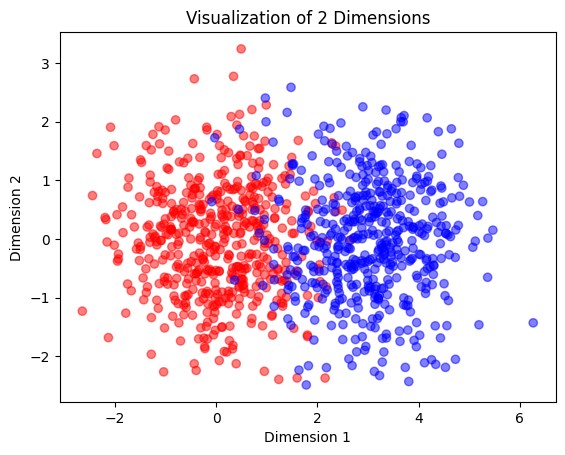

In [83]:
colors = {1: 'blue', -1: 'red'}

plt.scatter(x=X[:, 0], y=X[:, 1], c=[colors[label] for label in y], alpha = 0.5)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Visualization of 2 Dimensions')
plt.show()

<a id = "part2a"></a>

## Visualization

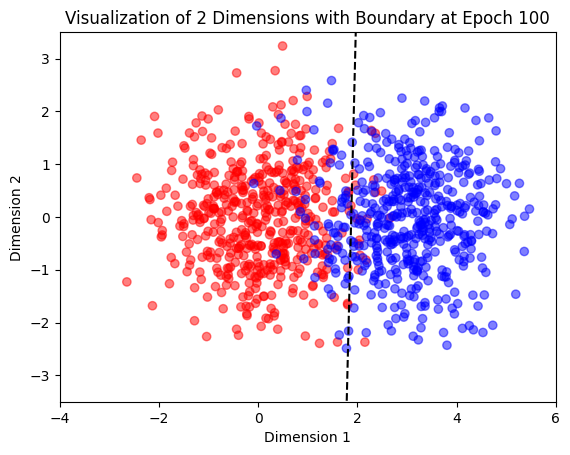

Did not converge within the specified maximum number of iterations.


In [84]:
model1 = PerceptronClassifier()
model1.setGraphDim(-4,6,-3.5,3.5)
model1.fit(X, y, max_epochs= 100,visualize = True, speed = 0)

<a id = "part2b"></a>
#### Trying different $m$, dimensions, and samples

In [77]:
ms = np.linspace(start = 0, stop = 6, num = 9)
dimensions = [2, 5, 10, 15, 20, 30, 50]
samples = [10,100,1000,5000,10000]

test_size = 10000
resultsNS = {}

for m in tqdm(ms):
    for d in dimensions:   
        X_test, y_test = generateNSData(dimensions = d, samples = test_size, m = m)
        for s in samples:
            total_iter = 0
            total_accuracy = 0
            for i in range(20):
                model = PerceptronClassifier()
                #print(f"m = {m:.2f}, dimensions = {d}, samples = {s}")
                X_train, y_train = generateNSData(dimensions = d, samples = s, m = m)
                model.fit(X_train, y_train, max_epochs= 100)
                y_pred = model.predict(X_test)
                total_accuracy += calculateMetric(y_pred, y_test)
                total_iter += model.iterations
            resultsNS[m,d,s] = [total_iter/20, total_accuracy/20]

100%|██████████| 9/9 [00:50<00:00,  5.56s/it]


<a id = "part2c"> </a>

#### Graphs

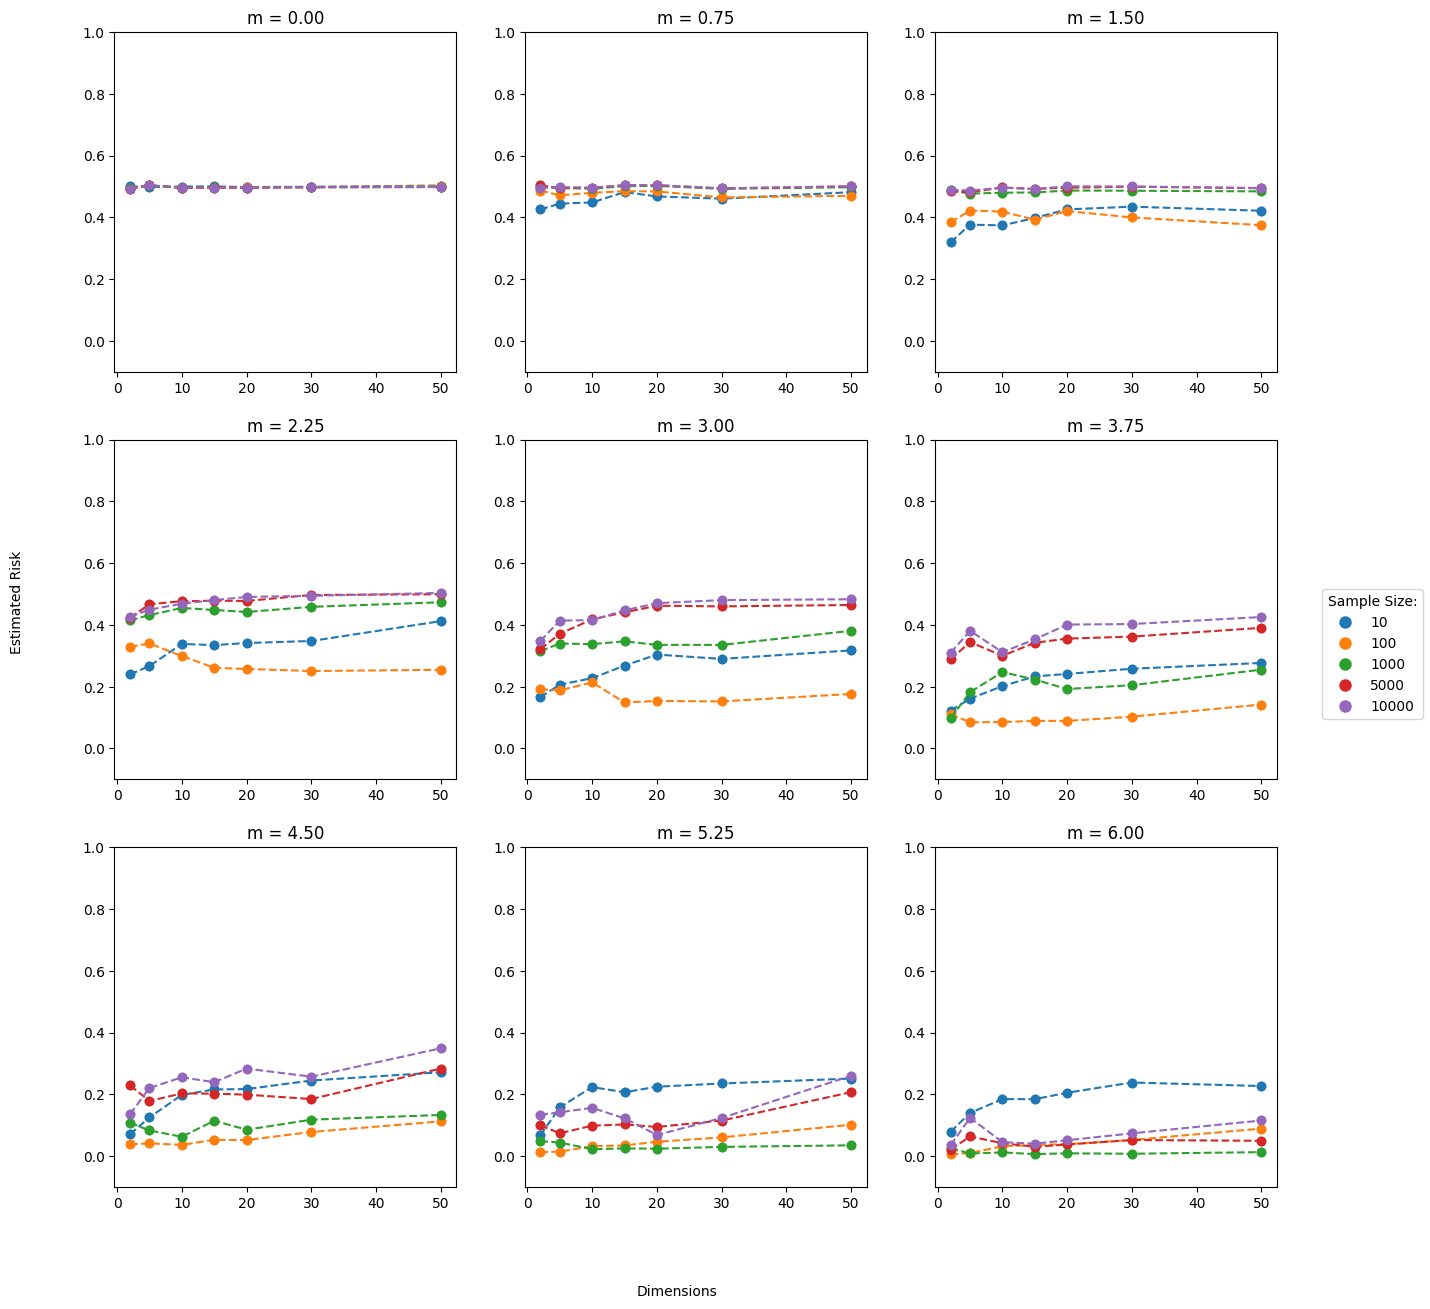

In [78]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(samples)]
converged_colors = dict(zip(samples, colors))

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, m in enumerate(ms):
    selected_ms = {k: v for k, v in resultsNS.items() if k[0] == m}

    for s in samples:

        selected_samples = {k: v for k, v in selected_ms.items() if k[2] == s}

        plot_x = [sublist[1] for sublist in selected_samples.keys()]
        plot_y = [1 - sublist[1] for sublist in selected_samples.values()]

        row = 0
        if i > 2:
            row = 1
        if i > 5:
            row = 2

        scatter = axs[row, i % 3].scatter(x=plot_x, y=plot_y, c=converged_colors[s], label=f"Graph for Samples {s}")

        axs[row, i % 3].set_title(f"m = {m:.2f}")

        axs[row, i % 3].plot(plot_x, plot_y, linestyle='--', marker='o', color=converged_colors[s])
        axs[row, i % 3].set_ylim(-0.1, 1)

fig.text(0.5, 0.04, 'Dimensions', ha='center', va='center')
fig.text(0.06, 0.5, 'Estimated Risk', ha='center', va='center', rotation='vertical')

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=converged_colors[s], markersize=10, linestyle='--', label=f'{s}') for s in samples]
fig.legend(handles=legend_labels, title='Sample Size:', loc='center right')

plt.show()

## Part 3: Comparing to Bayes Risk

In [79]:
from scipy.stats import norm

In [80]:
bayes_risk = {}
for m in ms:
    bayes_risk[m] = 1 - norm.cdf(x = m/2)
    
bayes_risk

{0.0: 0.5,
 0.75: 0.35383023332727626,
 1.5: 0.22662735237686826,
 2.25: 0.13029451713680884,
 3.0: 0.06680720126885809,
 3.75: 0.030396361765261393,
 4.5: 0.012224472655044671,
 5.25: 0.004332448363012609,
 6.0: 0.0013498980316301035}

<a id = "part3"> </a>

#### Comparison 
I plotted this risks again, but this time, with the Bayes Risk, which seems, as expected, to provide a bit of a lower bound for the risk of the other estimators (with the exception of few cases overfitting or getting lucky)

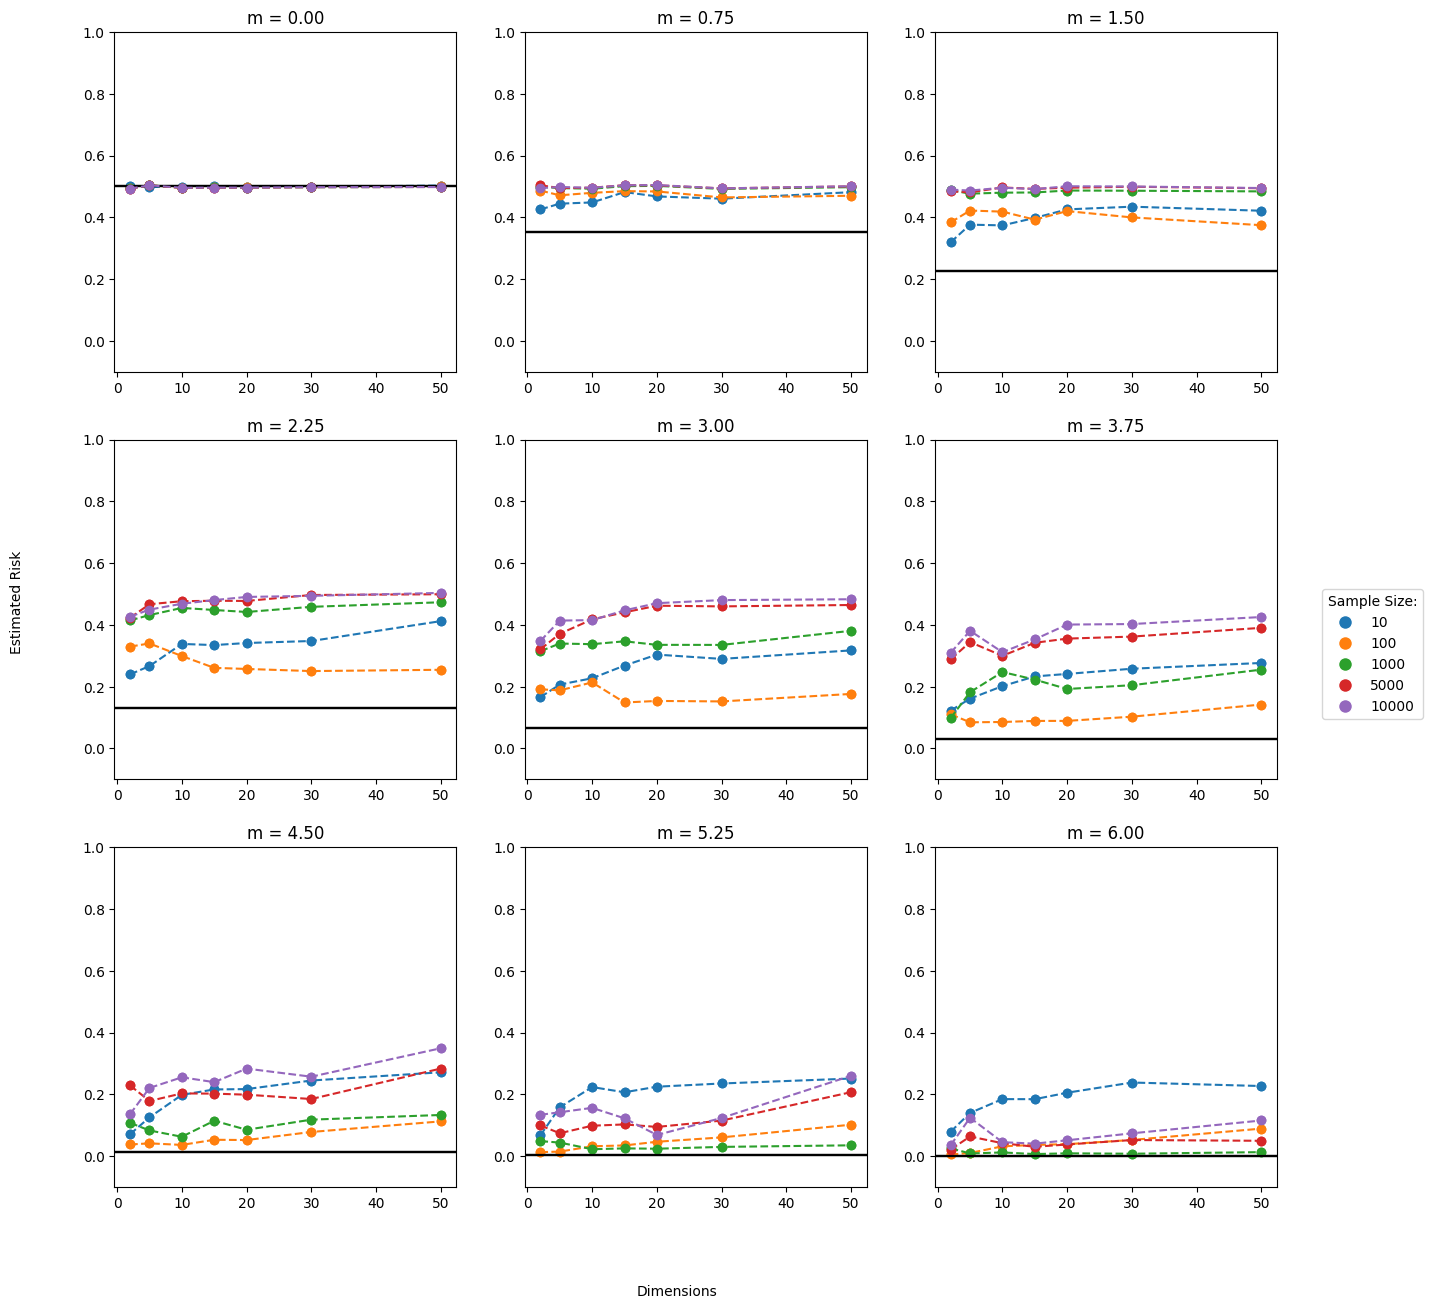

In [81]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(samples)]
converged_colors = dict(zip(samples, colors))

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, m in enumerate(ms):
    selected_ms = {k: v for k, v in resultsNS.items() if k[0] == m}

    for s in samples:
        selected_samples = {k: v for k, v in selected_ms.items() if k[2] == s}

        plot_x = [sublist[1] for sublist in selected_samples.keys()]
        plot_y = [1 - sublist[1] for sublist in selected_samples.values()]

        row = 0
        if i > 2:
            row = 1
        if i > 5:
            row = 2
        axs[row, i % 3].axhline(y=list(bayes_risk.values())[i], color='black',  label=f'Bayes Risk for m={m}')

        scatter = axs[row, i % 3].scatter(x=plot_x, y=plot_y, c=converged_colors[s], label=f"Graph for Samples {s}")

        axs[row, i % 3].set_title(f"m = {m:.2f}")

        axs[row, i % 3].plot(plot_x, plot_y, linestyle='--', marker='o', color=converged_colors[s])
        axs[row, i % 3].set_ylim(-0.1, 1)

fig.text(0.5, 0.04, 'Dimensions', ha='center', va='center')
fig.text(0.06, 0.5, 'Estimated Risk', ha='center', va='center', rotation='vertical')

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=converged_colors[s], markersize=10, linestyle='--', label=f'{s}') for s in samples]
fig.legend(handles=legend_labels, title='Sample Size:', loc='center right')

plt.show()